<p align="center">
  <span style="color:Navy; font-size:200%; font-weight:bold; vertical-align:middle;">
    Temas Selectos: Python para Ciencias de la Tierra
  </span>
  <img src="attachment:LOGO_ENCIT.png" alt="ENCiT" width="150" style="vertical-align:middle; margin-left:20px;"/>
</p>
<p align="center" style="line-height:1.2;">
  <span style="color:RoyalBlue; font-size:160%;">Tema 3: Análisis espacial</span><br/>
  <span style="color:DodgerBlue; font-size:140%;">Notebook 3: Rasterio </span><br/>
  <span style="font-size:100%;color:forestgreen"> Escuela Nacional de Ciencias de la Tierra  |  Semestre 2026-I</span>
</p>

---

## ¿Qué es Rasterio y para qué sirve?

Rasterio (sobre GDAL) permite trabajar con **datos ráster geoespaciales** (GeoTIFF, COG, etc.) como si fueran **arreglos NumPy** con georreferenciación (CRS, tamaño de píxel, transformada). Con Rasterio puedes:
- **Leer** bandas completas o **ventanas** (subconjuntos) sin cargar todo el archivo.
- Consultar y cambiar **CRS**, **resolución** y **extensión espacial**.
- **Recortar** por bounding box, **reproyectar** y **exportar** resultados.

A continuación usaremos **datos abiertos** (un GeoTIFF de prueba público) para ejemplos rápidos.


In [3]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

### ¿Qué es un archivo .tif / GeoTIFF y dónde conseguir datos?

Un **GeoTIFF** (`.tif`) es un ráster (matriz de píxeles) que además guarda **georreferenciación** dentro del archivo: sistema de coordenadas (CRS), tamaño de píxel, extensión espacial y valor “nodata”. Es el formato estándar para imágenes satelitales, modelos de elevación (DEM) y muchos productos ambientales.  
Variantes modernas como **COG** (Cloud-Optimized GeoTIFF) permiten leer el archivo por “trozos” vía web sin descargarlo completo.

**Ejemplos de uso**
- Imágenes satelitales multibanda (Landsat, Sentinel).
- DEMs (SRTM, Copernicus DEM) para pendiente/orientación.
- Productos climáticos (temperatura, precipitación, índices).
- Mapas temáticos clasificados (uso de suelo, cobertura).

**Dónde encontrar GeoTIFF abiertos**
- **USGS EarthExplorer** – escenas Landsat, SRTM, múltiples colecciones.  
  https://earthexplorer.usgs.gov/
- **Copernicus Open Access Hub / Data Space** – Sentinel-1/2/3/5P.  
  https://dataspace.copernicus.eu/
- **NASA Earthdata** (LP DAAC, GES DISC) – MODIS, VIIRS, climatología.  
  https://earthdata.nasa.gov/
- **AWS Open Data** (COGs listos para streaming: Landsat, Sentinel-2, DEMs).  
  https://registry.opendata.aws/
- **Microsoft Planetary Computer** (STAC + COG, catálogos curados).  
  https://planetarycomputer.microsoft.com/catalog
- **OpenTopography** (DEMs y derivados).  
  https://opentopography.org/
- **WorldClim / CHELSA** (clima global en GeoTIFF).  
  https://www.worldclim.org/  |  https://chelsa-climate.org/
- **ESA WorldCover** (cobertura terrestre global).  
  https://worldcover2020.esa.int/

**Tips para clase**
- Empieza con archivos **pequeños** o recortes regionales.  
- Prefiere **COG** cuando sea posible: carga más rápida en la nube.  
- Verifica CRS y resolución antes de calcular distancias/áreas.  
- Si el sitio requiere cuenta (USGS/NASA), descarga una muestra y súbela al entorno del curso.

**Muestras rápidas**
- Archivo de prueba de Rasterio (RGB pequeño) para ejercicios básicos:  
  https://raw.githubusercontent.com/rasterio/rasterio/main/tests/data/RGB.byte.tif


In [7]:
# 1) Abrir el GeoTIFF (RGB) desde una URL pública
url_tif = "https://raw.githubusercontent.com/rasterio/rasterio/main/tests/data/RGB.byte.tif"
with rio.open(url_tif) as src:
    # 2) Inspeccionar metadatos principales
    print("CRS:", src.crs)
    print("Bandas:", src.count)
    print("Tamaño (ancho, alto):", (src.width, src.height))

    # 3) Leer las 3 bandas (R,G,B) como arreglos 2D (alto x ancho)
    r = src.read(1)  # banda 1 = rojo
    g = src.read(2)  # banda 2 = verde
    b = src.read(3)  # banda 3 = azul

CRS: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bandas: 3
Tamaño (ancho, alto): (791, 718)


### ¿Qué estamos haciendo y por qué usar Rasterio?

Hasta ahora abrimos un *GeoTIFF* y miramos sus metadatos (CRS, tamaño, número de bandas) para entender **qué es** y **cómo está georreferenciado**. Con **Rasterio**, cada ráster se trata como:
- una **matriz NumPy** (los píxeles y sus valores), y
- un **conjunto de metadatos geoespaciales** (CRS, resolución, transformada, nodata).

Esta combinación permite leer solo lo necesario (bandas específicas o subventanas), inspeccionar la georreferenciación y preparar el dato para análisis cuantitativos y mapas reproducibles.

*¿Para qué le sirve a un/a geocientífico/a?*  
- **Sensores remotos**: abrir mosaicos satelitales (Landsat, Sentinel), calcular índices espectrales (NDVI, NDSI), componer RGB/false color.  
- **Superficie y relieve**: leer DEMs, derivar pendiente, orientación y curvatura; extraer perfiles topográficos.  
- **Hidrología**: recortes por cuenca, enmascarar cuerpos de agua, reamostrar a resoluciones homogéneas.  
- **Clima**: productos ráster (precipitación, temperatura, sequía) → estadísticas por región (mean/percentiles por polígono).  
- **Cambio espacial**: comparar escenas multitemporales (antes/después), detectar anomalías y generar mapas temáticos.

En resumen: **Rasterio** es la puerta de entrada para **leer**, **recortar**, **reproyectar** y **exportar** rásteres de forma confiable, apoyándose en NumPy para el cálculo y en Matplotlib/GeoPandas para visualizar y cruzar con capas vectoriales.


In [9]:
# 4) Construir un arreglo RGB (alto x ancho x 3)
rgb = np.dstack([r, g, b]).astype("float32")

# 5) Normalizar a 0–1 para mostrar (si ya estuviera en 0–255, no hace falta)
rgb_min = rgb.min()
rgb_max = rgb.max()
rgb = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-9)

(-0.5, 790.5, 717.5, -0.5)

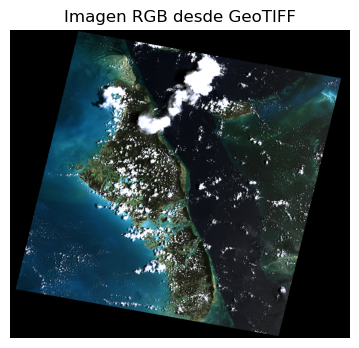

In [10]:
# 6) Visualizar
plt.figure(figsize=(5,4))
plt.imshow(rgb)
plt.title("Imagen RGB desde GeoTIFF")
plt.axis("off")

In [14]:
from rasterio.windows import from_bounds

### Lectura por “ventana” con Rasterio: qué es y por qué sirve

Un ráster es una **rejilla de píxeles** posicionada en la Tierra mediante una transformación afín (el `transform`) y un **CRS**.  
A veces no queremos leer la imagen completa (por tamaño o velocidad), sino solo un rectángulo del raster: a eso Rasterio le llama una **ventana**.

En la siguiente celda se:
1) Inspecciona el ráster para conocer su **extensión espacial** (`bounds`) y su **transform**.  
2) Elije un **bounding box** (minx, miny, maxx, maxy) **dentro de** `bounds`.  
3) Con `from_bounds(...)` convierte ese bbox (en coordenadas del mapa) a una *ventana de píxeles* (filas/columnas).  
4) Lee *solo esa ventana* con `src.read(window=win)`.  
5) Si quiero guardar el recorte, debo actualizar `width`, `height` y el nuevo `transform` que describe la georreferenciación del recorte.

Ventaja: ahorro memoria/tiempo y trabajo exactamente en la zona de interés, manteniendo la georreferenciación correcta.

In [16]:
with rio.open(url_tif) as src:
    # Imprime el CRS (sistema de referencia), útil para saber en qué unidades/coords está el ráster
    print("CRS:", src.crs)
    # Imprime la extensión espacial: (minx, miny, maxx, maxy)
    print("Bounds:", src.bounds)
    # Imprime la transformación afín: mapea pixeles (fila, col) ↔ coords del mapa (x, y)
    print("Transform:", src.transform)

    # Desempaqueta la extensión para construir un bbox centrado y más pequeño
    minx, miny, maxx, maxy = src.bounds
    # Centro del ráster
    cx = (minx + maxx) / 2.0
    cy = (miny + maxy) / 2.0
    # Tamaño del recorte (30% de la anchura/altura del ráster)
    dx = (maxx - minx) * 0.15
    dy = (maxy - miny) * 0.15
    # Bounding box elegido (en las mismas coordenadas que el ráster)
    bbox = (cx - dx, cy - dy, cx + dx, cy + dy)
    print("BBox elegido:", bbox)

    # Convierte el bbox (coords del mapa) a una ventana (en píxeles), usando el transform del dataset
    win = from_bounds(*bbox, transform=src.transform)
    # Muestra la ventana resultante: (desplazamiento de columna, desplazamiento de fila, ancho, alto)
    print("Ventana (col_off, row_off, width, height):", (win.col_off, win.row_off, win.width, win.height))

    # Lee solo esa ventana. 'data' tiene forma (bandas, filas, columnas)
    data = src.read(window=win)



CRS: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=101985.0, bottom=2611485.0, right=339315.0, top=2826915.0)
Transform: | 300.04, 0.00, 101985.00|
| 0.00,-300.04, 2826915.00|
| 0.00, 0.00, 1.00|
BBox elegido: (185050.5, 2686885.5, 256249.5, 2751514.5)
Ventana (col_off, row_off, width, height): (276.8500000000001, 251.29999999999927, 237.3, 215.39999999999964)


(-0.5, 236.5, 214.5, -0.5)

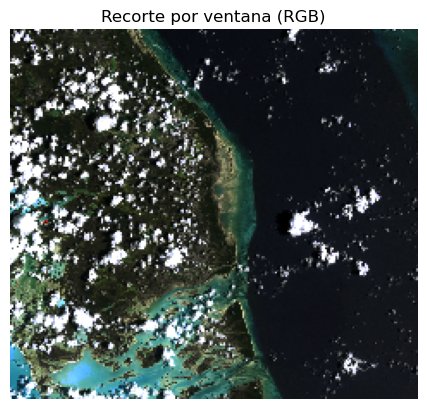

In [18]:
# Apila las tres primeras bandas como imagen RGB
rgb = np.dstack([data[0], data[1], data[2]]).astype("float32")
# Normaliza a 0–1 para visualizar
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)
plt.imshow(rgb)
plt.title("Recorte por ventana (RGB)")
plt.axis("off")